In [9]:
import os, json, shutil
from pathlib import Path

import torch
from torchvision import models
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

INPUT_DIR  = r"../data/raw"
OUTPUT_DIR = r"../data/sorted"
RESULTS_CSV = r"../data/classifier_results.csv"

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
TOP1_THRESHOLD = 0.25  

KEYWORDS = {
    "people": ["person","man","woman","boy","girl","bride","groom","diver","skier","player","guitarist","singer"],
    "bird":   ["bird","eagle","hawk","falcon","parrot","duck","goose","swan","owl","hen","rooster"],
    "animal": ["dog","cat","lion","tiger","leopard","bear","horse","cow","sheep","goat","pig","deer","monkey","rabbit","fox","wolf"],
    "vehicle":["car","taxi","bus","truck","motorcycle","bike","bicycle","train","airplane","helicopter","boat","ship","sail"],
    "indoor": ["sofa","couch","chair","table","desk","lamp","tv","monitor","keyboard","bed"],
    "outdoor":["mountain","beach","forest","valley","cliff","lakeside","seashore","desert"],
    "building":["castle","palace","mosque","church","pagoda","barn","bridge","lighthouse"],
}
DEFAULT_CLASS = "other"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights).to(device).eval()
preprocess = weights.transforms()
classes = weights.meta["categories"]

Device: cuda


In [5]:
def list_images(root: str):
    root = Path(root)
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in EXTS:
            files.append(p)
    return sorted(files)

def predict_topk(img_path: Path, k=5):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        return None 
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        top_prob, top_idx = probs.topk(k)
    names = [classes[i] for i in top_idx.tolist()]
    return top_idx.tolist(), names, top_prob.tolist()

def map_to_coarse(names):
    low = [n.lower() for n in names]
    for coarse, kws in KEYWORDS.items():
        for n in low:
            if any(kw in n for kw in kws):
                return coarse
    return DEFAULT_CLASS


In [10]:
files = list_images(INPUT_DIR)
print("Found images:", len(files))

rows = []
for p in tqdm(files, desc="Classifying"):
    pred = predict_topk(p, k=5)
    if pred is None:
        continue
    idxs, names, probs = pred
    top1_prob = probs[0]
    coarse = map_to_coarse(names) if top1_prob >= TOP1_THRESHOLD else DEFAULT_CLASS
    rows.append({
        "path": str(p),
        "top1_name": names[0],
        "top1_prob": top1_prob,
        "top5_name": json.dumps(names),
        "top5_prob": json.dumps(probs),
        "coarse": coarse
    })

df = pd.DataFrame(rows)
df.to_csv(RESULTS_CSV, index=False)
df.head()

Found images: 110000


Classifying: 100%|██████████| 110000/110000 [15:28<00:00, 118.41it/s]


,path,top1_name,top1_prob,top5_name,top5_prob,coarse
0,../data/raw/fake/0 (10).jpg,moving van,0.204091,"[""moving van"", ""milk can"", ""espresso maker"", ""...","[0.2040911763906479, 0.034591443836688995, 0.0...",other
1,../data/raw/fake/0 (2).jpg,moving van,0.173163,"[""moving van"", ""cassette"", ""cassette player"", ...","[0.17316292226314545, 0.03860437124967575, 0.0...",other
2,../data/raw/fake/0 (3).jpg,platypus,0.063699,"[""platypus"", ""black grouse"", ""otter"", ""water o...","[0.06369943916797638, 0.0461534708738327, 0.02...",other
3,../data/raw/fake/0 (4).jpg,milk can,0.397394,"[""milk can"", ""Madagascar cat"", ""colobus"", ""pol...","[0.39739418029785156, 0.11154504120349884, 0.0...",animal
4,../data/raw/fake/0 (5).jpg,gazelle,0.178581,"[""gazelle"", ""coyote"", ""hartebeest"", ""English f...","[0.1785813570022583, 0.04376276582479477, 0.03...",other


In [11]:
out = Path(OUTPUT_DIR)
out.mkdir(parents=True, exist_ok=True)

for _, r in tqdm(df.iterrows(), total=len(df), desc="Copying"):
    src = Path(r["path"])
    dst_dir = out / r["coarse"]
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst = dst_dir / src.name
    if not dst.exists():
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            print("COPY ERROR:", src, "->", dst, e)

print("Done. Classes distribution:")
print(df["coarse"].value_counts())

Copying: 100%|██████████| 110000/110000 [00:13<00:00, 8447.20it/s] 

Done. Classes distribution:
coarse
other       95544
animal       6456
vehicle      3592
people       3491
building      604
indoor        161
bird          107
outdoor        45
Name: count, dtype: int64


# Verify classification

In [24]:
import matplotlib.pyplot as plt

def verify_classification(category, idx):
    img_path = f"../data/sorted/{category}/"
    img_path += os.listdir(f'../data/sorted/{category}')[idx]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(category)
    plt.show()

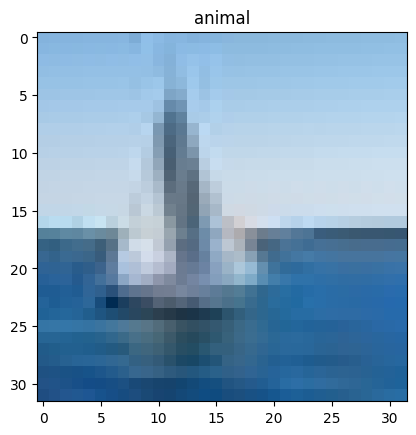

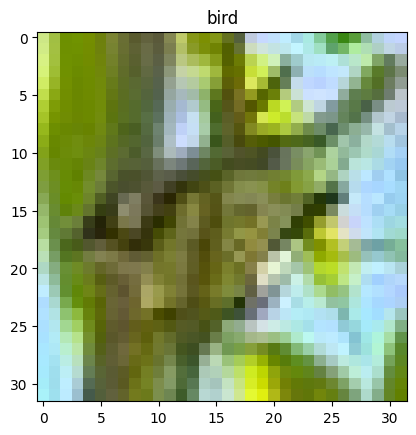

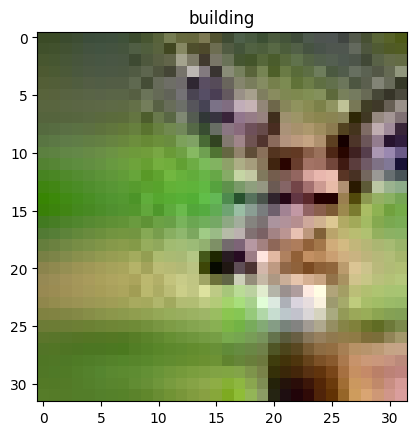

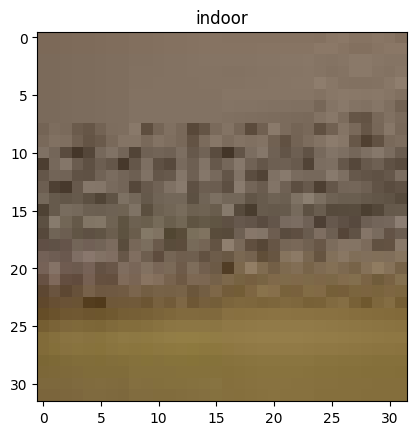

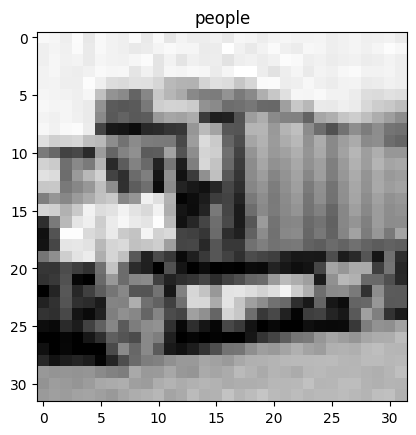

In [27]:
verify_classification('animal', 10)
verify_classification('bird', 10)
verify_classification('building', 10)
verify_classification('indoor', 10)
verify_classification('people', 10)


This shows clearly that the classifier fails to classify this dataset

# repeating the same steps with a different dataset

In [1]:
import os, json, shutil
from pathlib import Path

import torch
from torchvision import models
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

INPUT_DIR_TEST  = r"../dataset2/test_data_v2"
INPUT_DIR_TRAIN = r"../dataset2/train_data"

EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
TOP1_THRESHOLD = 0.25  

KEYWORDS = {
    "people": ["person","man","woman","boy","girl","bride","groom","diver","skier","player","guitarist","singer"],
    "bird":   ["bird","eagle","hawk","falcon","parrot","duck","goose","swan","owl","hen","rooster"],
    "animal": ["dog","cat","lion","tiger","leopard","bear","horse","cow","sheep","goat","pig","deer","monkey","rabbit","fox","wolf"],
    "vehicle":["car","taxi","bus","truck","motorcycle","bike","bicycle","train","airplane","helicopter","boat","ship","sail"],
    "indoor": ["sofa","couch","chair","table","desk","lamp","tv","monitor","keyboard","bed"],
    "outdoor":["mountain","beach","forest","valley","cliff","lakeside","seashore","desert"],
    "building":["castle","palace","mosque","church","pagoda","barn","bridge","lighthouse"],
}
DEFAULT_CLASS = "other"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights).to(device).eval()
preprocess = weights.transforms()
classes = weights.meta["categories"]

/home/user/PML_Project/ai-image-detector-comparison/pml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
def list_images(root: str):
    root = Path(root)
    files = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in EXTS:
            files.append(p)
    return sorted(files)

def predict_topk(img_path: Path, k=5):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        return None 
    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        top_prob, top_idx = probs.topk(k)
    names = [classes[i] for i in top_idx.tolist()]
    return top_idx.tolist(), names, top_prob.tolist()

def map_to_coarse(names):
    low = [n.lower() for n in names]
    for coarse, kws in KEYWORDS.items():
        for n in low:
            if any(kw in n for kw in kws):
                return coarse
    return DEFAULT_CLASS


In [9]:
df_train = pd.read_csv("../dataset2/train.csv")
files = df_train["file_name"]
classifications = []

for p in tqdm(files, desc="Classifying"):
    pred = predict_topk(f"../dataset2/{p}", k=5)
    if pred is None:
        continue
    idxs, names, probs = pred
    top1_prob = probs[0]
    coarse = map_to_coarse(names) if top1_prob >= TOP1_THRESHOLD else DEFAULT_CLASS
    classifications.append(coarse)

Classifying: 100%|██████████| 79950/79950 [15:22<00:00, 86.66it/s]  


In [16]:
len(files)

79950

In [18]:
df_train["coarse"] = classifications

In [21]:
df_train.head()

,Unnamed: 0,file_name,label,coarse
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,other
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,other
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,other
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,other
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,other


In [48]:
import matplotlib.pyplot as plt

def verify_classification_df(category, df, idx):
    df_cat = df[df['coarse'] == category]
    img_path = f"../dataset2/{df_cat['file_name'].iloc[idx]}"
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(category)
    plt.show()

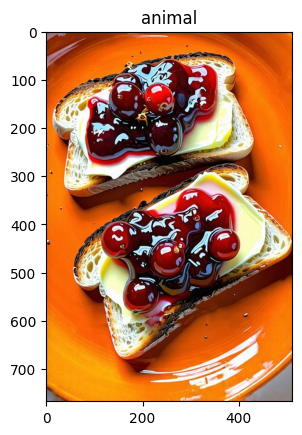

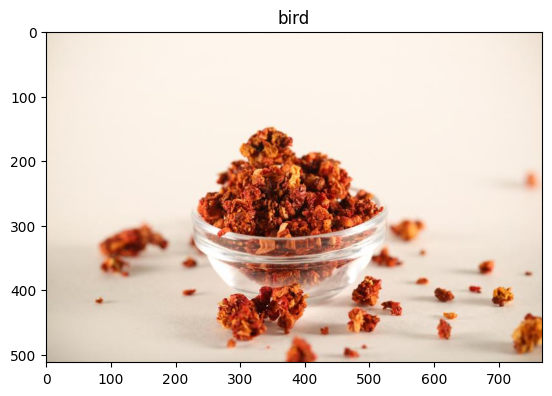

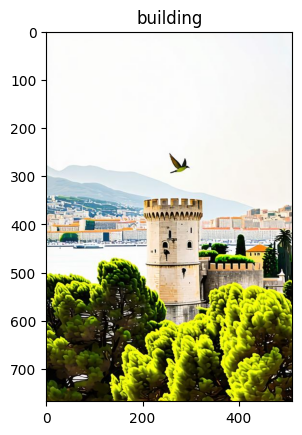

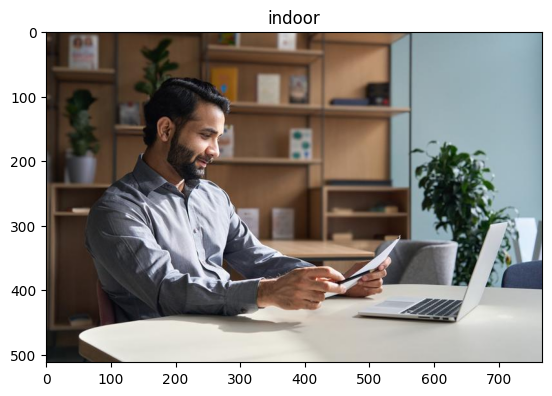

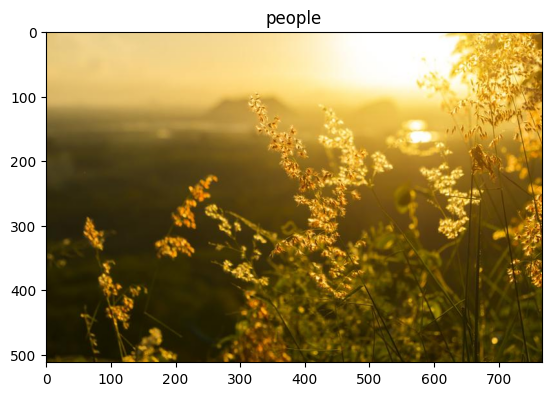

In [49]:
verify_classification_df('animal', df_train, 10)
verify_classification_df('bird', df_train, 10)
verify_classification_df('building', df_train, 10)
verify_classification_df('indoor', df_train, 10)
verify_classification_df('people', df_train, 10)
